# SPICED ACADEMY  //  WEEK 07  //  TEMPERATURE FORECASTING
Brunno Gorgulho Soares

---

# 0. Set Up

## 0.a. Modules

In [1]:
''' Essentials '''
import pandas as pd
import numpy as np

''' Plotting '''
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
plt.rcParams['figure.figsize'] = (18, 4)

''' Feature Engineering '''
from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from statsmodels.tsa.ar_model import AutoReg, ar_select_order

''' Modelling '''
from sklearn.linear_model import LinearRegression
import pmdarima as pm
from statsmodels.tsa.arima.model import ARIMA

''' Hyperparameter Optimization '''
from sklearn.model_selection import TimeSeriesSplit

## 0.b. Efficiency

In [2]:
plot = True

---

# 1. Business Goal
Develop a predictive model for weather using past data. 

---

# 2. Get Data

In [3]:
df = pd.read_csv('data/TG_STAID002759.csv', na_values='-9999', parse_dates=['date'], index_col=['date'])
df = df.drop(['souid','q_tg'], axis=1)

---

# 3. Train-Test Split

## 3.a. Removing NAs before Train-Test Splitting

In [4]:
''' As rows are not randomly assigned train / test, NAs are checked before splitting. '''


'''Temperature # NAs: 195'''
print(df['tg'].isna().sum())


'''Lowest date value for NA is 1945-04-25 and highest 1945-11-05.'''
df_nas = df[df['tg'].isna()==True].index
print(df_nas.min(), df_nas.max())


'''Imputing a large number of consecutive data points will not be trivial, therefore data prior to 1946 is dropped.'''
df = df[df.index>='1946-01-01']


'''Double-checking for 0 NAs, and it is true.'''
print(df['tg'].isna().sum())

195
1945-04-25 00:00:00 1945-11-05 00:00:00
0


## 3.b. Train-Test Splitting Remaining Rows

In [5]:
''' Goal is to split data into train and test sets by approx. 75% & 25%, avoiding over-representing any single datevalue. '''

''' To avoid over-representation of any date value, date range is limited to max  '''
end_date_month = df.index.max().month
end_date_day = df.index.max().day
start_date = pd.to_datetime(f'{df.index.min().year}-{end_date_month}-{end_date_day}') + pd.Timedelta('1 day')
end_date = df.index.max()
print(start_date, end_date)
assert type(start_date) == type(end_date)

''' 75% is equivalent to about 22133 rows. '''
split_nearest_index = int(df['tg'].groupby(df.index.year).count().sum() * (4/5))
print(split_nearest_index)

''' 22133th row's date vlaue is 2006. '''
split_year = df.index[split_nearest_index].year
print(split_year)

'''  '''
train_start_date = start_date
train_end_date = pd.to_datetime(f'{split_year}-{end_date_month}-{end_date_day}')

test_start_date = pd.to_datetime(f'{split_year}-{end_date_month}-{end_date_day}') + pd.Timedelta('1 day')
test_end_date = end_date

''' Hence train is from 1946 to 2006 and test from 2007 onwards. '''
df_train = df[(df.index >= train_start_date) & (df.index <= train_end_date)]
df_test = df[(df.index >= test_start_date) & (df.index <= test_end_date)]

print('Train starts:', df_train.index.min(), 'Train ends:', df_train.index.max())
print('Test starts:', df_test.index.min(), 'Test ends :', df_test.index.max())

1946-10-01 00:00:00 2021-09-30 00:00:00
22133
2006
Train starts: 1946-10-01 00:00:00 Train ends: 2006-09-30 00:00:00
Test starts: 2006-10-01 00:00:00 Test ends : 2021-09-30 00:00:00


In [6]:
''' X and y are separated. X is reshaped to prevent breaking feature engineering function. '''

X = np.reshape(df_train.index, (-1,1))
y = df_train['tg']

---

# 4. Explore Data

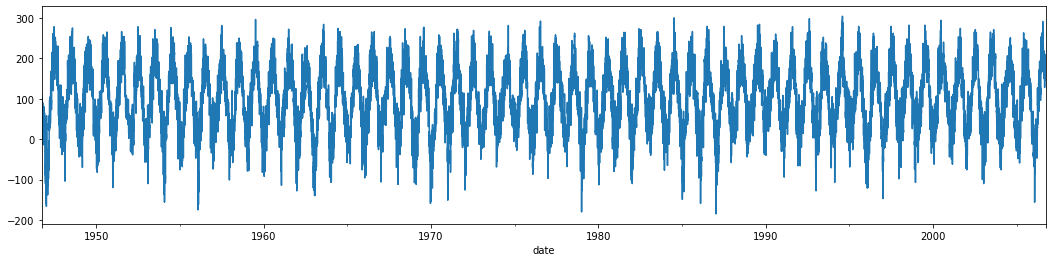

In [7]:
''' Process appears to be weakly stationary. '''

if plot: df_train['tg'].plot()

---

# 5. Feature Engineering

## 5.a. Execution

Below I define all functions to be used in the Feature Engineering pipeline.

In [8]:
def timestep_detrend(df):

    ''' Sub-function to remove_seasonal_trend. Adds timestamp column for trend modelling. '''

    df['timestep'] = list(range(len(df)))
    return df



def ohe_deseasonal(df, season_granularity):
 
    ''' Sub-function to remove_seasonal_trend. Adds one-hot encoded columns for seasonality modelling. '''
    
    if season_granularity=='month':
        df_month = pd.get_dummies(data=df.index.month, drop_first=True, prefix='month').set_index(df.index)
        df = df.join(df_month)

    elif season_granularity=='weeknum':
        df_weeknum = pd.get_dummies(data=df.index.weekofyear, drop_first=True, prefix='weeknum').set_index(df.index)
        df = df.join(df_weeknum)

    else:
        raise Exception('Try one of: month, weeknum in ohe_deseasonal function.')

    return df



def remove_trend_seasonal(df, season_granularity='month'):

    ''' Creates new y column removing trend and seasonality. '''
    
    df = timestep_detrend(df) # timestamp column helps de-trending
    df = ohe_deseasonal(df, season_granularity) # one-hot encoded seasonal columns help de-seasonalization
    
    X = df.drop(['tg'], axis=1)
    y = df['tg']

    m1 = LinearRegression()
    m1.fit(X, y)
    df['trend_seasonal'] = m1.predict(X)

    df['remainder'] = df['tg'] - df['trend_seasonal']

    return df



def lag(df, n=3):

    ''' Creates lag functions for lags 1 to n. Drops NAs '''
    
    for iter in range(1,n+1):
        df[f'lag{iter}'] = df['remainder'].shift(iter)
    
    df = df.dropna() # Drops NAs generated through lags.

    return df



def standard_scale(x):
 
    '''  '''  
    
    x_scaled = (x - x.mean())/x.std()
    
    return x_scaled



def scale_columns (df, columns_list):

    ''' Splits dataframe into y (tg) and X vriables. '''
    
    for column in columns_list:
        df[column] = standard_scale(df[column])

    return df



def drop_cols(df):

    ''' Drops intermediary columns (after calculation of another column). '''

    df = df.drop(['trend_seasonal','remainder'], axis=1)
    return df

Below, I build the Feature Engineering pipeline applying the above-defined functions.

In [9]:
# Call functions
get_no_trend_seasonal = FunctionTransformer(remove_trend_seasonal)
get_lags = FunctionTransformer(lag)
get_scaled_columns = FunctionTransformer(scale_columns, kw_args={'columns_list':['lag1','lag2','lag3']})
get_drop_cols = FunctionTransformer(drop_cols)

# Define pipeline
pipe_model_month = Pipeline([
    ('get_no_trend_seasonal', get_no_trend_seasonal),
    ('get_lags', get_lags),
    ('get_scaled_columns', get_scaled_columns),
    ('get_drop_cols', get_drop_cols)
])

# Fit pipeline using df_train and transform df_train
df_train_model = pipe_model_month.fit_transform(df_train)

## 5.b. Feature Engineering Exploration

ADD AUGMENTED DICKIE FULLER TEST ON REMAINDE

Below, I build the Feature Engienering for plotting, which may keep columns which are dropped in the modelling pipeline.

In [10]:
# Call functions
get_no_trend_seasonal = FunctionTransformer(remove_trend_seasonal)
get_lags = FunctionTransformer(lag)
get_scaled_columns = FunctionTransformer(scale_columns, kw_args={'columns_list':['lag1','lag2','lag3']})
get_drop_cols = FunctionTransformer(drop_cols)

# Define pipeline
pipe_plot = Pipeline([
    ('get_no_trend_seasonal', get_no_trend_seasonal),
    ('get_lags', get_lags),
    ('get_scaled_columns', get_scaled_columns)
])

# Fit pipeline using df_train and transform df_train
df_train_plot = pipe_plot.fit_transform(df_train)

# Split X and y
X_train_model = df_train_model.drop(['tg'], axis=1)
y_train_model = df_train_model['tg']

/opt/anaconda3/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [11]:
''' Strong correlation between remainder and its lags. ''' 
print(round(df_train_plot[['remainder','lag1','lag2','lag3']].corr(), 2))


''' The correlation between lag2 and remainder is fully explained by the indirect effect of lag2 through lag1. Why keep lag2? '''  
remainder_lag1_corr = 0.8
lag1_lag2_corr = 0.8
remainder_lag2_corr = 0.6
print('Partial_autocorrelation:', remainder_lag2_corr - (remainder_lag1_corr * lag1_lag2_corr))

           remainder  lag1  lag2  lag3
remainder       1.00   0.8   0.6  0.47
lag1            0.80   1.0   0.8  0.60
lag2            0.60   0.8   1.0  0.80
lag3            0.47   0.6   0.8  1.00
Partial_autocorrelation: -0.04000000000000015


In [12]:
''' According to Autoregressor test, keep lags 1, 2 and 3. '''

if plot: selected_order = ar_select_order(df_train_plot['remainder'], maxlag=20)
selected_order.ar_lags

/opt/anaconda3/envs/myenv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/opt/anaconda3/envs/myenv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


[1, 2, 3]

A clear cutoff is observed in lag 2 of the Partial Autocorrelation graph. Meanwhile, no cutoff is observed in the Autocorrelation plot, suggesting that this is an Autoregression problem, rather than Moving Average.

/opt/anaconda3/envs/myenv/lib/python3.7/site-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


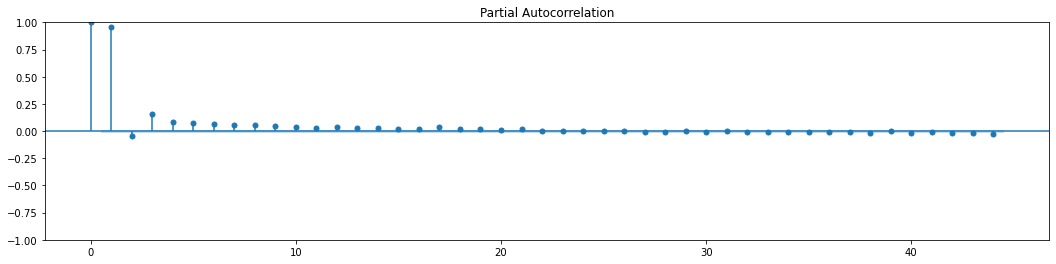

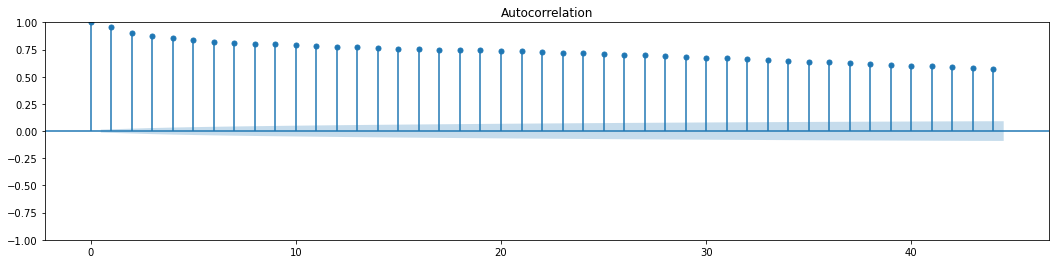

In [13]:
if plot: 
    plot_pacf(df_train_plot['tg'])
    plot_acf(df_train_plot['tg'])

---

# 6. Train Model

Now, I train a linear modelled as follows:

$ y_t = \beta_{0} + \beta_{1} X_{timestep,\ t} + \beta_{2} X_{Feb\_dummy,\ t} + ... + \beta_{12} X_{Dec\_dummy,\ t} + \beta_{13} X_{R,\ t-1} + \beta_{14} X_{R,\ t-2} + \beta_{15} X_{R, t-3} + \epsilon_{t} $ 

Where $ y_{t} $ is temperature in degrees celsius, $ X_{timestep} $ is the timestep value (linearized datetime), $ X_{Feb\_dummy} $ to $ X_{Dec\_dummy} $ are month one-hot encoded dummies, and $ X_{R, t-n} $ are the lags of the remainder (signal leftover after de-trending and de-seasonalizing).

In [15]:
''' Callinga and fitting model. '''

m2 = LinearRegression()
m2.fit(X_train_model, y_train_model)
df_train_model['pred_ar3'] = m2.predict(X_train_model)

In [16]:
print('M2 R2:', round(m2.score(X_train_model, y_train_model),2))

M2 R2: 0.91


---

In [17]:
# m4 = pm.auto_arima(df_train_m4, start_p

# )

# 'https://alkaline-ml.com/pmdarima/quickstart.html#quickstart'

In [18]:
''' This code was used to inspect for chronic under-prediction in peaks and over-prediction in troughs, which is not apparent. '''

# min_year_train = df_train_model.index.min().year
# max_year_train = df_train_model.index.max().year + 1
# if plot:
#     for year in range(min_year_train, max_year_train):
#         df_train_model[ (df_train_model.index >= f'{year}-01-01') & (df_train_model.index <= f'{year}-12-31')][['tg','pred_ar3']].plot(alpha=0.7, title=f'{year}')

' This code was used to inspect for chronic under-prediction in peaks and over-prediction in troughs, which is not apparent. '

---

# 7. Hyperparameter Optimization // Cross-Validation

---

# 8. Calculate Test Score

In [19]:
df_test_m2 = pipe_model_month.fit_transform(df_test)
X_test_m2 = pipe_model_month.transform(df_test).drop(['tg'], axis=1)
y_test_m2 = pipe_model_month.transform(df_test)['tg']

/opt/anaconda3/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

---

# 9. Deploy & Monitor

In [24]:
''' Creating Future Dataset '''

df_predict = df_test_m2

future_date = df_predict.index.max() + pd.to_timedelta('1 day') # future index
print(future_date)

print('Max timestep test set:', df_predict['timestep'].max())
future_timestamp = df_predict['timestep'].max() + 1 # future timestamp

future_ohe_months = [0 for n in range(11)]
future_ohe_months[future_date.month - 2] = 1 # future ohe_months; -2 is -1 due to python starting at 0 and another -1 due to dropped jan column
print(future_ohe_months)

future_lags = [df_predict['tg'][-1], df_predict['tg'][-2], df_predict['tg'][-3]] # lags
print(future_lags)

X_future = [future_timestamp] + (future_ohe_months) + (future_lags)
X_future = np.reshape(X_future, (1,-1))

X_future = pd.DataFrame(X_future, columns=[X_train_model.columns])

print(X_future)



2021-10-01 00:00:00
Max timestep test set: 5478
[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]
[117.0, 139.0, 157.0]
  timestep month_2 month_3 month_4 month_5 month_6 month_7 month_8 month_9  \
0   5479.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   

  month_10 month_11 month_12   lag1   lag2   lag3  
0      1.0      0.0      0.0  117.0  139.0  157.0  


In [ ]:
''' Creating Future Pipeline '''

get_scaled_columns = FunctionTransformer(scale_columns, kw_args={'columns_list':['lag1','lag2','lag3']})



pipe_model_future = Pipeline([
    ('scale', get_scaled_columns),
])



X_future_m2 = pipe_model_future.transform(X_future)

In [ ]:
m2.predict(X_future_m2)

In [ ]:
df_test_m2.iloc[[-1]]

In [ ]:
pd.DataFrame(X_future)

In [ ]:
m_pred = m2
m_pred.fit(X_test_m2, y_test_m2)
m_pred.predict(X_future)

In [ ]:
def forecast():
    ...

---

# 10. Appendix

In [ ]:
''' Using week instad of month to capture seasonality significantly improves nuance. '''
if plot:
    df_plot = df_train.copy()

    df_plot['month'] = df_plot.index.month
    df_plot['weekofyear'] = df_plot.index.weekofyear
    weekofyear_to_month = pd.Series(df_plot['month'].groupby(df_plot['weekofyear']).median())

    seasonality_weekofyear = pd.DataFrame(df_plot['tg'].groupby(df_plot['weekofyear']).mean()).reset_index()
    seasonality_weekofyear['month'] = seasonality_weekofyear['weekofyear'].map(weekofyear_to_month)

    seasonality_month = df_plot['tg'].groupby(df_plot['month']).mean()
    seasonality_weekofyear_month = pd.merge(left=seasonality_weekofyear, right=seasonality_month, how='left', left_on=seasonality_weekofyear['month'], right_on=seasonality_month.index)

    seasonality_weekofyear_month.set_index('weekofyear')['tg_x'].plot()
    seasonality_weekofyear_month.set_index('weekofyear')['tg_y'].plot()

In [ ]:
''' Building pipeline for modelling assuming WEEKNUM seasonality. '''

get_no_trend_seasonal = FunctionTransformer(remove_trend_seasonal, kw_args={'season_granularity':'weeknum'})
get_lags = FunctionTransformer(lag)
get_scaled_columns = FunctionTransformer(scale_columns, kw_args={'columns_list':['lag1','lag2','lag3']})
get_drop_cols = FunctionTransformer(drop_cols)



pipe_model_weeknum = Pipeline([
    ('no_trend_seasonal', get_no_trend_seasonal),
    ('lags', get_lags),
    ('scale', get_scaled_columns),
    ('drop_cols', get_drop_cols)
])

In [ ]:
''' Transforming Data and Splitting X-y '''

df_train_m3 = pipe_model_weeknum.fit_transform(df_train)
X_train_m3 = pipe_model_weeknum.transform(df_train).drop(['tg'], axis=1)
y_train_m3 = pipe_model_weeknum.transform(df_train)['tg']

''' Checking columns '''
assert list(X_train_m3.columns) == ['timestep', 'weeknum_2', 'weeknum_3', 'weeknum_4', 'weeknum_5',
       'weeknum_6', 'weeknum_7', 'weeknum_8', 'weeknum_9', 'weeknum_10',
       'weeknum_11', 'weeknum_12', 'weeknum_13', 'weeknum_14', 'weeknum_15',
       'weeknum_16', 'weeknum_17', 'weeknum_18', 'weeknum_19', 'weeknum_20',
       'weeknum_21', 'weeknum_22', 'weeknum_23', 'weeknum_24', 'weeknum_25',
       'weeknum_26', 'weeknum_27', 'weeknum_28', 'weeknum_29', 'weeknum_30',
       'weeknum_31', 'weeknum_32', 'weeknum_33', 'weeknum_34', 'weeknum_35',
       'weeknum_36', 'weeknum_37', 'weeknum_38', 'weeknum_39', 'weeknum_40',
       'weeknum_41', 'weeknum_42', 'weeknum_43', 'weeknum_44', 'weeknum_45',
       'weeknum_46', 'weeknum_47', 'weeknum_48', 'weeknum_49', 'weeknum_50',
       'weeknum_51', 'weeknum_52', 'weeknum_53', 'lag1', 'lag2', 'lag3']

In [ ]:
''' Calling and fitting model. '''

m3 = LinearRegression()
m3.fit(X_train_m3, y_train_m3)
df_train_m3['pred_ar3'] = m3.predict(X_train_m3)